# Lab 9 - Graph Data Analytics

Complete the code with TODO tag.

## 4. Graph Modularity and Louvain Algorithm (OPTIONAL)
### 4.1. Compute Modularity

In this exercise, we compute the modularity measure of a graph. First we create a small dataset and manually assign the community label to each node.

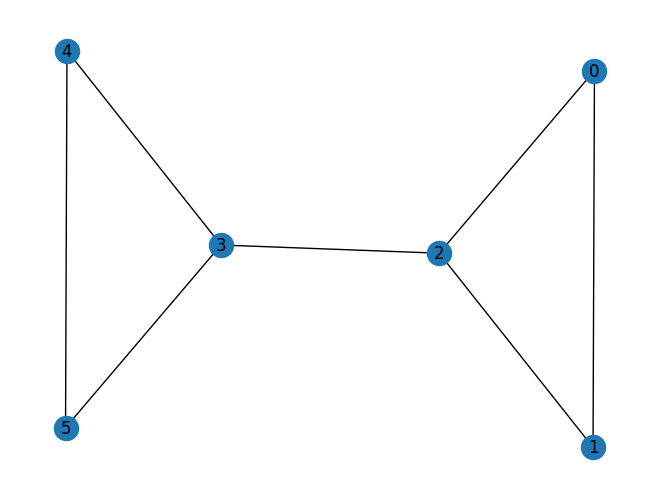

In [1]:
from __future__ import print_function, division
%matplotlib inline

import networkx as nx
import numpy as np

M = ["0,1,2",
"1,0,2",
"2,0,1,3",
"3,2,4,5",
"4,3,5",
"5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw(G, with_labels=True)

In [2]:
for node in [0,1,2]:
    G.nodes[node]['community'] = 0
for node in [3,4,5]:
    G.nodes[node]['community'] = 1

len(G.edges)

7

Now we compute the modularity of the graph given the current community assignment

In [4]:

def compute_modularity(G):
    '''
    TODO: compute the modularity of a networkx graph
    HINTS:
    + The community label of a node can be accessed by G.nodes[node_id]['community'] 
    + The degree of a node: G.degree[node_id]
    + The neighbors of a node: G.neighbors(node_id)
    + Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
    '''
    m = len(G.edges)
    Q = 0
    
    for i in G.nodes():
        for j in G.nodes():
            if G.nodes[i]['community'] == G.nodes[j]['community']:
                k_i = G.degree[i]
                k_j = G.degree[j]
                A_ij = G.number_of_edges(i, j)
                e_ij = k_i * k_j / (2 * m)
                Q += (A_ij - e_ij)
    
    return Q / (2 * m)

compute_modularity(G)

0.3571428571428571

### 4.2. Naive Louvain algorithm

It is convenient to use the adjacency matrix representation.

In [5]:
def adj_matrix(G):
    M = nx.adjacency_matrix(G)
    M = np.array(M.todense())
    return M
M = adj_matrix(G)
p = np.array([i for i in range(len(M))])
k = [sum(np.array(row).flatten()) for row in M]
m = sum(k) / 2 
print(M)
print(p)
print(k)
print(m)

[[0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 1 0 0]
 [0 0 1 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]]
[0 1 2 3 4 5]
[2, 2, 3, 3, 2, 2]
7.0


Now we implement phase 1 of Louvain algorithm, in which we partition the nodes to maximize the modularity

In [ ]:
def phase1(M, p=None, k=None):
    N = len(M)
    
    if p is None: p = np.array([i for i in range(N)])
    
    if k is None: k = np.array([sum(row) for row in M])
    
    m = sum(k) / 2

    improvement = True
    while improvement:
        improvement = False
        for i in range(N):
            p_max = p[i]
            delta_Q_max = 0
            for j in range(N):
                if M[i][j] == 0: continue
                Q_plus = 0 
                Q_minus = 0 
                
                for l in range(N):
                    if p[l] == p[j]:
                        Q_plus += M[i][l] - k[i] * k[l] / (2 * m)
                    if p[l] == p[i]:
                        Q_minus += M[i][l] - k[i] * k[l] / (2 * m)
                delta_Q = Q_plus - Q_minus
                
                if delta_Q_max < delta_Q:
                    delta_Q_max = delta_Q
                    p_max = p[j]
            
            p[i] = p_max

            if not improvement and delta_Q_max > 0:
                improvement = True
    return p

phase1(M)

Now we implement the phase 2 of Louvain algorithm, in which we merge the nodes within the same community to a single node and create edges between communities.

In [ ]:
def phase2(M, p):
    N = len(M)
    communities = np.unique(p)
    C = len(communities)
    communities = dict(zip(communities, range(len(communities))))
    
    M_new = np.array([[0] * C for x in communities])
    
    
    for i in range(N):
        for j in range(N):
            if M[i][j] == 0: continue
            if p[i] == p[j]: continue
            M_new[communities[p[i]]][communities[p[j]]] += M[i][j]
    
    return M_new

M_new = phase2(M, phase1(M))
p_new = phase1(M_new)
M_new, p_new

Now we can implement the full Louvain algorithm

In [ ]:
def louvain(M, verbose=True):
    C = len(M)
    iter = 0
    M_new = M
    print("Level 0 partition: {0}".format(np.array([i for i in range(C)])))
    while C > 1:
        iter += 1
        p = phase1(M_new)
        M_new = phase2(M_new, p)
        C = len(M_new)
        print("Level {0} partition: {1}".format(iter, p))
        
louvain(M)

### 4.3. Efficient Louvain algorithm

The naive Louvain algorithm is not efficient. It takes $O(n^3)$. There are some improvements in the literature

+ http://www.ijcee.org/vol8/927-A023.pdf
+ https://www.cs.upc.edu/~CSN/slides/07communities.pdf
+ https://en.wikipedia.org/wiki/Louvain_Modularity
+ https://www.quora.com/Is-there-a-simple-explanation-of-the-Louvain-Method-of-community-detection
+ http://arxiv.org/abs/0803.0476
+ https://stackoverflow.com/questions/22070196/community-detection-in-networkx

For simplicity, we will demo one existing implementation. You can try to improve the final visualization further.

```bash
conda install python-louvain
```

In [ ]:
!conda install python-louvain -y
import community

partition = community.best_partition(G)

def visualize(G, partition):
    import matplotlib.pyplot as plt
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count += 1.
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()
    return

visualize(G, partition)

### 4.4. Efficiency comparison

We load a larger network and compare the running time of the two implementations.

In [ ]:
G = nx.karate_club_graph()
nx.draw(G)

In [ ]:
import time
M = adj_matrix(G)
p = np.array([i for i in range(len(M))])
k = np.array([sum(row) for row in M])

start_time = time.time()
p = phase1(M, p, k)
print("--- %s seconds ---" % (time.time() - start_time))
print(p)

In [ ]:
start_time = time.time()
p = community.best_partition(G)
print("--- %s seconds ---" % (time.time() - start_time))
print(p)
visualize(G, p)

Now we load an even larger network: https://snap.stanford.edu/data/email-Eu-core.html

In [ ]:
G = nx.read_edgelist("email-Eu-core.txt")
nx.draw(G)
print(nx.info(G))

In [ ]:
start_time = time.time()
p = community.best_partition(G)
print("--- %s seconds ---" % (time.time() - start_time))
# print(p)
visualize(G, p)

In [ ]:

M = adj_matrix(G)
p = np.array([i for i in range(len(M))])
k = np.array([sum(row) for row in M])

start_time = time.time()
p = phase1(M, p, k)
print("--- %s seconds ---" % (time.time() - start_time))
print(p)